# Financial Analytics (Time Series Data)

In [1]:
#install.packages("tidyverse")
#install.packages("xts")
#install.packages("lubridate")
#install.packages("forecast")

# LOAD PACKAGES SUPRESS WARNINGS
library(xts)
library(tidyverse)
library(lubridate)
library(forecast)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks xts::last()

Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [2]:
# Import the kraken dataset as kraken_df
kraken_df = read_csv("data/kraken.csv")

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  crypto = col_character(),
  pct_change = col_double(),
  price = col_double(),
  volume = col_double(),
  trend = col_character(),
  all_time_high = col_logical(),
  new_crypto = col_logical()
)


In [3]:
head(kraken_df)

datetime,crypto,pct_change,price,volume,trend,all_time_high,new_crypto
2020-08-05 03:48:49,XBT,0.0040,11194.0000,111100000,down,FALSE,FALSE
2020-08-05 03:48:49,ETH,0.0080,389.8100,68800000,up,FALSE,FALSE
2020-08-05 03:48:49,XRP,0.0320,0.3010,20300000,down,FALSE,FALSE
2020-08-05 03:48:49,USDT,0.0001,1.0005,18600000,down,FALSE,FALSE
2020-08-05 03:48:49,LINK,0.0650,9.8602,14800000,up,FALSE,FALSE
2020-08-05 03:48:49,XTZ,0.0540,3.2424,10300000,up,FALSE,FALSE


## Data Preprocessing

In [4]:
kraken_df$trend = kraken_df$trend %>%
                    str_replace_all("up","1") %>% 
                    str_replace_all("down","-1") %>%
                    str_replace_all("flat","0") %>%
                    as.numeric()

In [5]:
kraken_df$date = as.Date(kraken_df$datetime)
kraken_df$time = format(kraken_df$datetime,"%H:%M:%S")
kraken_df$crypto = as_factor(kraken_df$crypto)
kraken_df$all_time_high = as.numeric(kraken_df$all_time_high)
kraken_df$new_crypto = as.numeric(kraken_df$new_crypto)

In [6]:
summary(kraken_df[c("date","crypto","price","volume")])

      date                crypto          price               volume         
 Min.   :2017-06-12   XBT    : 1053   Min.   :    0.001   Min.   :      518  
 1st Qu.:2018-05-16   ETH    : 1053   1st Qu.:    1.000   1st Qu.:   286709  
 Median :2019-04-01   XRP    : 1053   Median :   11.560   Median :  1090000  
 Mean   :2019-03-06   USDT   : 1053   Mean   :  487.156   Mean   : 11007116  
 3rd Qu.:2020-01-19   LTC    : 1053   3rd Qu.:  114.770   3rd Qu.:  4440000  
 Max.   :2020-08-05   XLM    : 1053   Max.   :19020.000   Max.   :829000000  
                      (Other):12967                                          

In [7]:
summary(kraken_df[c("trend","pct_change","all_time_high", "new_crypto")])

     trend            pct_change      all_time_high        new_crypto      
 Min.   :-1.00000   Min.   :0.00000   Min.   :0.000000   Min.   :0.000000  
 1st Qu.:-1.00000   1st Qu.:0.00960   1st Qu.:0.000000   1st Qu.:0.000000  
 Median : 0.00000   Median :0.02480   Median :0.000000   Median :0.000000  
 Mean   :-0.01177   Mean   :0.04029   Mean   :0.007156   Mean   :0.001141  
 3rd Qu.: 1.00000   3rd Qu.:0.05300   3rd Qu.:0.000000   3rd Qu.:0.000000  
 Max.   : 1.00000   Max.   :1.07400   Max.   :1.000000   Max.   :1.000000  

## Exploring ETH

In [8]:
eth_df = kraken_df[kraken_df$crypto == 'ETH' & kraken_df$date <= '2020-07-04', ]
summary(eth_df['price'])

     price       
 Min.   :  82.1  
 1st Qu.: 171.9  
 Median : 225.5  
 Mean   : 305.5  
 3rd Qu.: 328.8  
 Max.   :1293.8  

In [9]:
#Question 1: What is the mean price of ETH over the time of our collected data?
eth = kraken_df[kraken_df$crypto == 'ETH',]
summary(eth['price'])

     price       
 Min.   :  82.1  
 1st Qu.: 172.6  
 Median : 228.8  
 Mean   : 304.8  
 3rd Qu.: 327.5  
 Max.   :1293.8  

In [10]:
#Question 2: What date did we reach the highest price of ETH?
tail(eth[order(eth$price),])
#OR
eth[which.max(eth$price),]

datetime,crypto,pct_change,price,volume,trend,all_time_high,new_crypto,date,time
2018-01-08 22:03:46,ETH,0.0582,1144.2,2.38e+08,1,1,0,2018-01-08,22:03:46
2018-01-20 22:03:15,ETH,0.0962,1156.3,1.34e+08,1,0,0,2018-01-20,22:03:15
2018-01-29 22:03:08,ETH,0.0396,1164.1,1.44e+08,-1,0,0,2018-01-29,22:03:08
2018-01-28 22:03:59,ETH,0.0919,1212.1,2.23e+08,1,0,0,2018-01-28,22:03:59
2018-01-09 22:03:48,ETH,0.0772,1232.6,2.08e+08,1,1,0,2018-01-09,22:03:48
2018-01-10 22:03:50,ETH,0.0497,1293.8,2.71e+08,1,1,0,2018-01-10,22:03:50


datetime,crypto,pct_change,price,volume,trend,all_time_high,new_crypto,date,time
2018-01-10 22:03:50,ETH,0.0497,1293.8,2.71e+08,1,1,0,2018-01-10,22:03:50


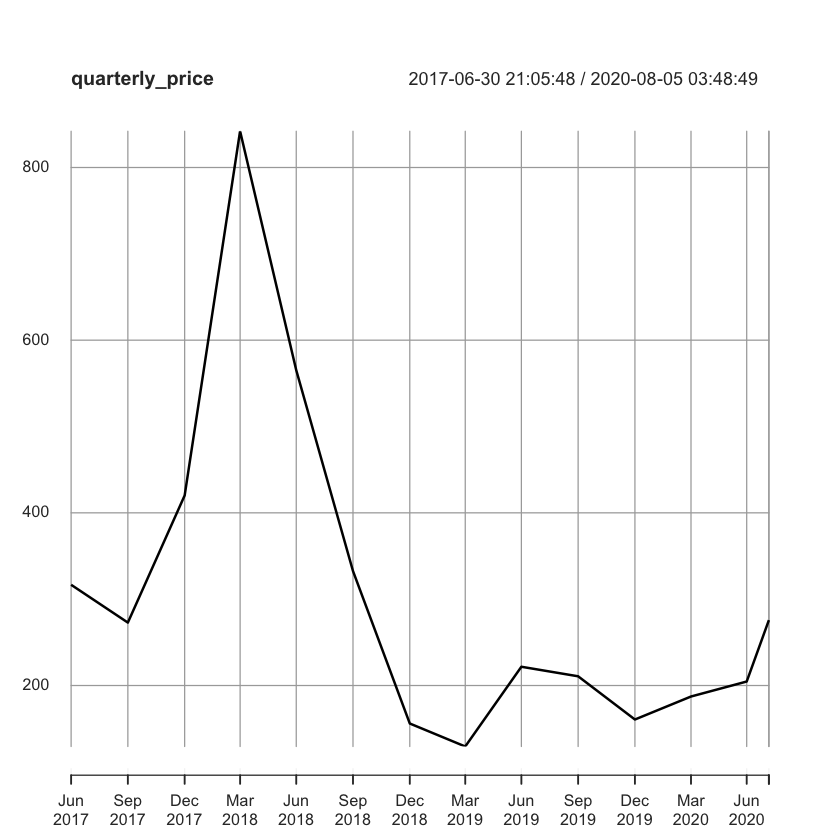

In [11]:
#Question 3: When did ETH have a price peak based on its quarterly average price curve?
dt = select(eth,c("datetime"))$datetime
eth_ts = xts(select(eth,-c("datetime","date","time")), 
             order.by = as.POSIXct(strptime(dt,"%Y-%m-%d %H:%M:%S")))
daily_price = eth_ts[,'price']
quarterly_price = apply.quarterly(daily_price, mean)
#plot quarterly prices
plot(quarterly_price, yaxis.right = FALSE)

In [12]:
#Question 4: What was the biggest percentage change in ETH's price over the data we collected?
max(eth$pct_change)

[1] 0.37

In [13]:
#Question 5: What is the lowest price of ETH?
min(eth$price)

[1] 82.1

## Exploring XBT

In [14]:
xbt_df = kraken_df[kraken_df$crypto == "XBT",]

# Remove the crypto column in extracted subset
xbt_df = select(xbt_df, -c("crypto"))

In [15]:
head(xbt_df)

datetime,pct_change,price,volume,trend,all_time_high,new_crypto,date,time
2020-08-05 03:48:49,0.0040,11194,111100000,-1,0,0,2020-08-05,03:48:49
2020-08-04 03:28:35,0.0160,11246,134400000,1,0,0,2020-08-04,03:28:35
2020-08-03 02:56:14,0.0610,11084,250500000,-1,0,0,2020-08-03,02:56:14
2020-08-02 02:24:13,0.0400,11820,201400000,1,0,0,2020-08-02,02:24:13
2020-08-01 02:57:23,0.0200,11350,144700000,1,0,0,2020-08-01,02:57:23
2020-07-31 03:17:57,0.0005,11117,130800000,1,0,0,2020-07-31,03:17:57


In [16]:
dt = select(xbt_df,c("datetime"))$datetime
xbt_ts = xts(select(xbt_df,-c("datetime","date","time")), 
             order.by = as.POSIXct(strptime(dt,"%Y-%m-%d %H:%M:%S")))

In [18]:
# Display the beginning of XBT dataset
head(xbt_ts)

                    pct_change price   volume trend all_time_high new_crypto
2017-06-12 21:07:38     0.1030  2593 9.49e+07    -1             0          0
2017-06-13 21:07:38     0.0473  2715 7.52e+07     1             0          0
2017-06-14 21:07:38     0.0588  2556 7.68e+07    -1             0          0
2017-06-15 21:07:38     0.0875  2332 1.35e+08    -1             0          0
2017-06-16 21:04:35     0.0694  2494 7.39e+07     1             0          0
2017-06-17 21:07:38     0.0557  2633 4.90e+07     1             0          0

In [19]:
daily_price = xbt_ts[,'price']
weekly_price = apply.weekly(daily_price, mean)
monthly_price = apply.monthly(daily_price, mean)
quarterly_price = apply.quarterly(daily_price, mean)

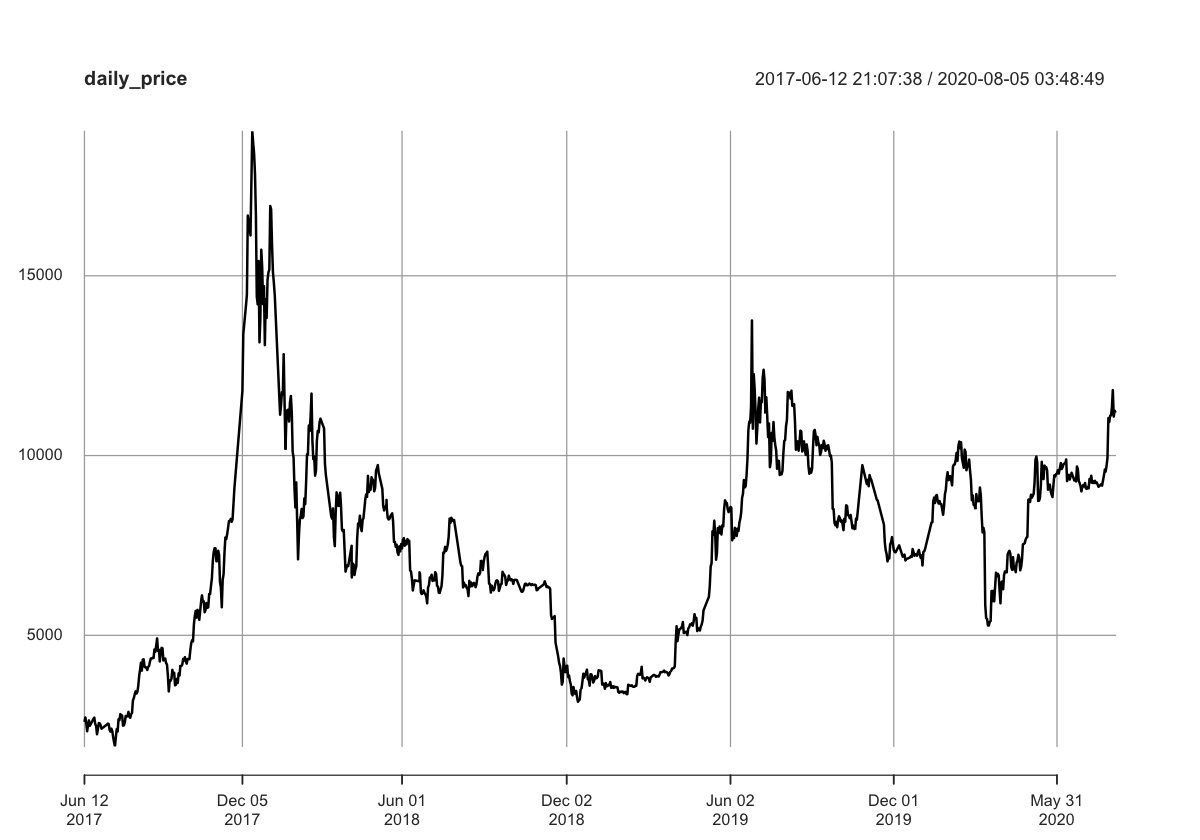

In [20]:
# Adjusting figure size, you can change the width and height
options(repr.plot.width=10, repr.plot.height=7) 

# Plot XBT daily prices over time 
plot(daily_price, yaxis.right = FALSE)

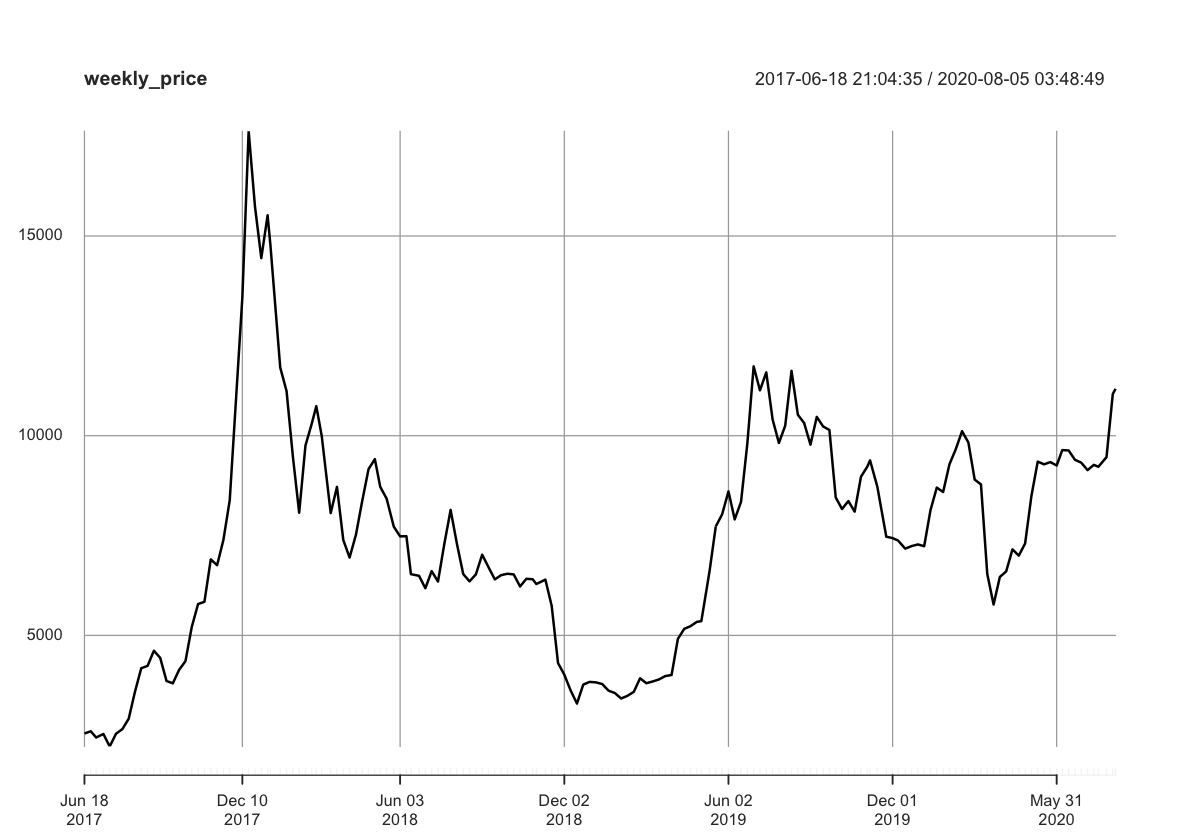

In [21]:
# Plot XBT weekly average prices over time 
plot(weekly_price, yaxis.right = FALSE)

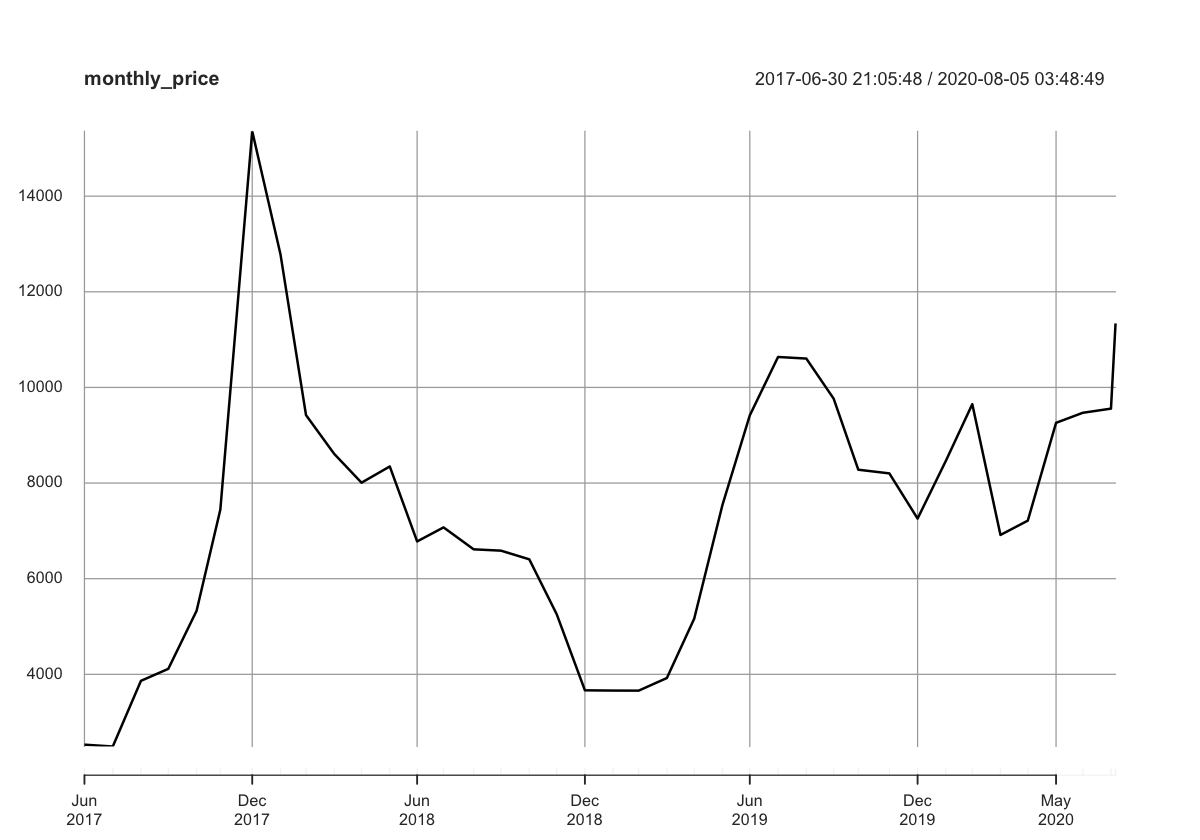

In [22]:
# Plot XBT monthly average prices over time 
plot(monthly_price, yaxis.right = FALSE)

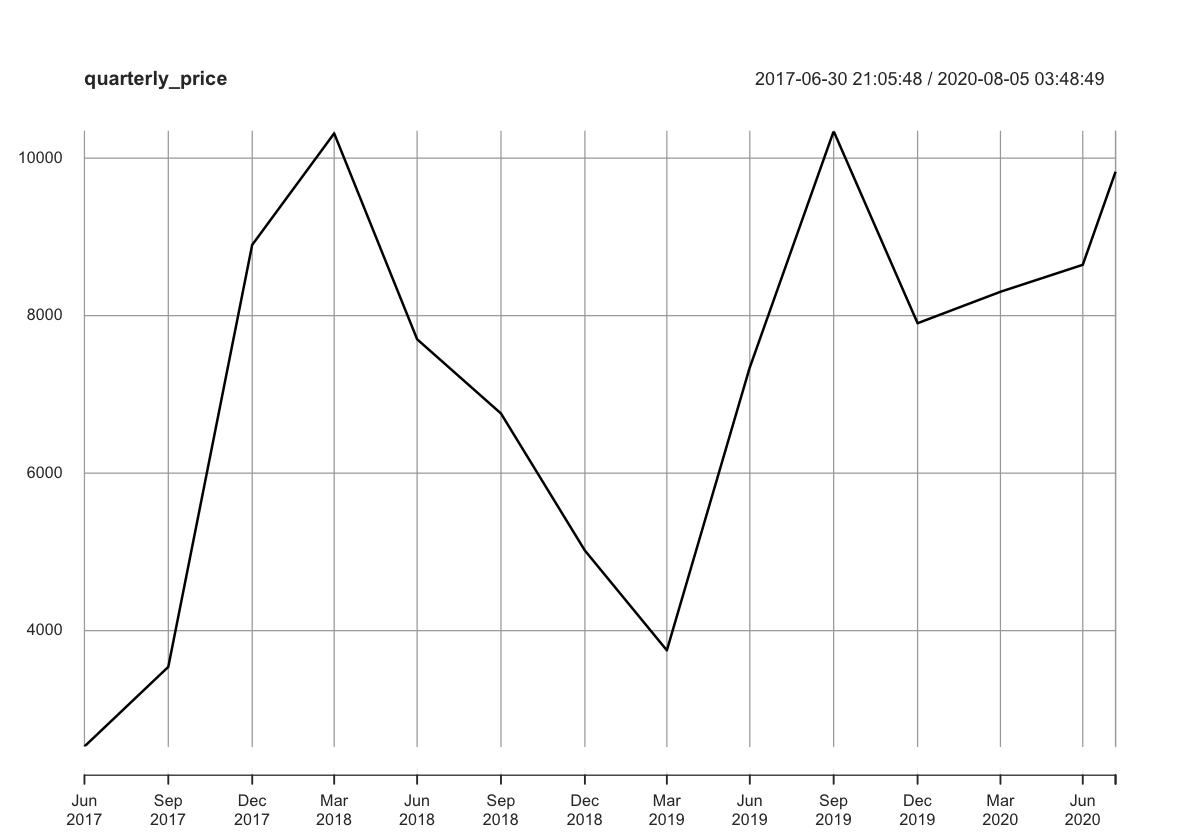

In [23]:
# Plot XBT quarterly average prices over time 
plot(quarterly_price, yaxis.right = FALSE) 

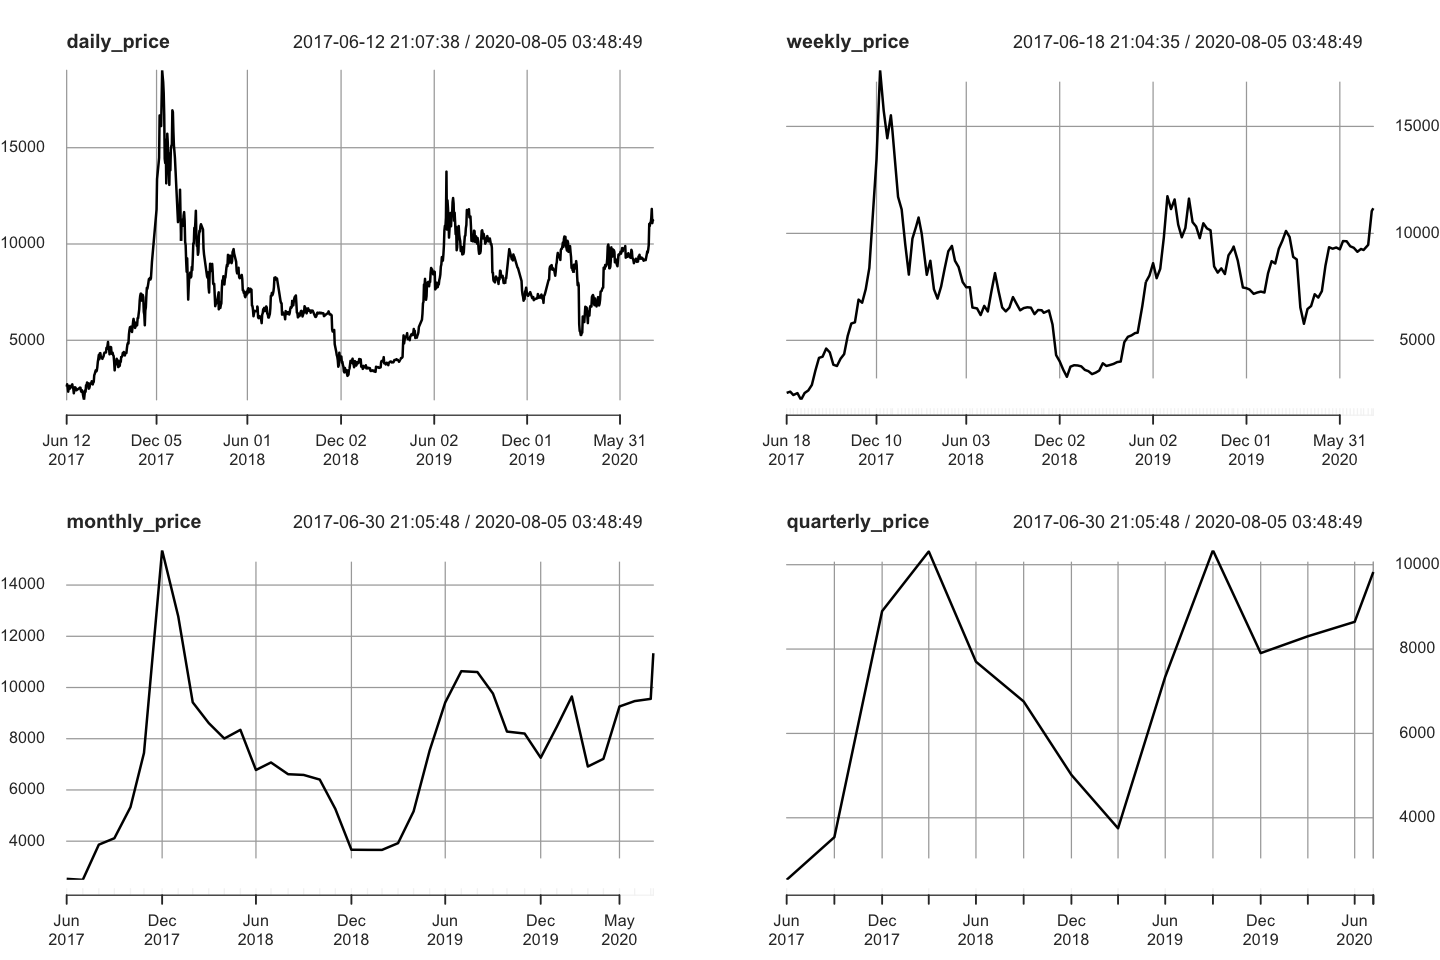

In [24]:
# Allows you to create four plots in 2 rows x 2 columns
par(mfrow=c(2,2))

# Adjusting figure size, you can change the width and height
options(repr.plot.width=12, repr.plot.height=8) 

# Create price curves:
plot(daily_price, yaxis.right = FALSE)
plot(weekly_price, yaxis.left = FALSE)
plot(monthly_price, yaxis.right = FALSE)
plot(quarterly_price, yaxis.left = FALSE)